# 日経平均株価 15分足

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.commons import get_name_15min_chart, get_name_15min_chart_usd

In [3]:
code = "N225"
symbol = f"^{code}"
yticker = yf.Ticker(symbol)
df = yticker.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2026-02-06 09:00:00+09:00,53435.371094,53454.621094,53021.351562,53047.460938,0,0.0,0.0
2026-02-06 09:15:00+09:00,53069.949219,53399.261719,52950.148438,53375.109375,0,0.0,0.0
2026-02-06 09:30:00+09:00,53374.718750,53521.648438,53374.718750,53444.550781,0,0.0,0.0
2026-02-06 09:45:00+09:00,53462.519531,53529.660156,53378.238281,53529.660156,0,0.0,0.0
2026-02-06 10:00:00+09:00,53533.531250,53606.531250,53376.648438,53403.378906,0,0.0,0.0
2026-02-06 10:15:00+09:00,53400.730469,53441.171875,53277.898438,53344.648438,0,0.0,0.0
2026-02-06 10:30:00+09:00,53348.089844,53544.910156,53341.750000,53543.781250,0,0.0,0.0
2026-02-06 10:45:00+09:00,53543.730469,53745.871094,53541.011719,53737.601562,0,0.0,0.0
2026-02-06 11:00:00+09:00,53737.460938,53982.640625,53737.460938,53978.300781,0,0.0,0.0


In [4]:
dt_start = df.index[0]
dt_end = pd.to_datetime(
    f"{dt_start.year:04d}-{dt_start.month:02d}-{dt_start.day:02d} 15:30:00+09:00"
).tz_convert("Asia/Tokyo")
dt_start, dt_end

(Timestamp('2026-02-06 09:00:00+0900', tz='Asia/Tokyo'),
 Timestamp('2026-02-06 15:30:00+0900', tz='Asia/Tokyo'))

In [5]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = yticker.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# lastclose = 50168.11 # 12/15 終値
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2026-01-30 00:00:00+09:00    53322.851562
2026-02-02 00:00:00+09:00    52655.179688
2026-02-03 00:00:00+09:00    54720.660156
2026-02-04 00:00:00+09:00    54293.359375
2026-02-05 00:00:00+09:00    53818.039062
2026-02-06 00:00:00+09:00    54190.160156
Name: Close, dtype: float64


Date
2026-02-05 00:00:00+09:00    53818.039062
Name: Close, dtype: float64

In [6]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

-382.67


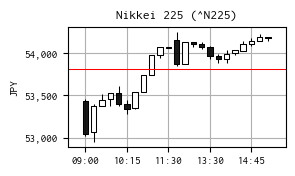

In [7]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose, color="red", linewidth=0.75)
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("JPY")
ax.grid()

if "shortName" in yticker.info:
    ax.set_title(f"{yticker.info['shortName']} ({symbol})")
elif "longName" in yticker.info:
    ax.set_title(f"{yticker.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()

In [8]:
code2 = "USDJPY=X"
symbol2 = code2
ticker2 = yf.Ticker(symbol2)

In [9]:
# 15分足で過去 2 日分のデータを取得
df_exchange = ticker2.history(period="2d", interval="15m")
df_exchange.index = df_exchange.index.tz_convert("Asia/Tokyo")
df_exchange

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2026-02-05 09:00:00+09:00,156.906006,156.955994,156.869003,156.908997,0,0.0,0.0
2026-02-05 09:15:00+09:00,156.908997,156.953995,156.906006,156.934998,0,0.0,0.0
2026-02-05 09:30:00+09:00,156.923996,156.985992,156.871002,156.886002,0,0.0,0.0
2026-02-05 09:45:00+09:00,156.891006,156.891006,156.699997,156.776993,0,0.0,0.0
2026-02-05 10:00:00+09:00,156.778000,156.904007,156.774994,156.865005,0,0.0,0.0
...,...,...,...,...,...,...,...
2026-02-06 14:30:00+09:00,156.615997,156.768997,156.615997,156.735992,0,0.0,0.0
2026-02-06 14:45:00+09:00,156.740005,156.761993,156.681000,156.751007,0,0.0,0.0
2026-02-06 15:00:00+09:00,156.755997,156.901993,156.748993,156.830994,0,0.0,0.0


In [10]:
ser_rate = df_exchange.loc[df.index, "Close"]
ser_rate
df2 = pd.DataFrame()
df2["Open"] = df["Open"] / ser_rate
df2["High"] = df["High"] / ser_rate
df2["Low"] = df["Low"] / ser_rate
df2["Close"] = df["Close"] / ser_rate
df2

,Open,High,Low,Close
Datetime,,,,
2026-02-06 09:00:00+09:00,341.049986,341.172849,338.407516,338.574159
2026-02-06 09:15:00+09:00,338.538367,340.639083,337.774146,340.485013
2026-02-06 09:30:00+09:00,340.491205,341.428507,340.491205,340.936681
2026-02-06 09:45:00+09:00,341.279896,341.708491,340.741884,341.708491
2026-02-06 10:00:00+09:00,341.752842,342.218867,340.751318,340.921962
2026-02-06 10:15:00+09:00,341.118449,341.376784,340.333810,340.760202
2026-02-06 10:30:00+09:00,340.616847,341.873506,340.576369,341.866298
2026-02-06 10:45:00+09:00,341.800506,343.090887,341.783151,343.038097
2026-02-06 11:00:00+09:00,342.772433,344.336348,342.772433,344.308666


In [11]:
dt = df_exchange.head(1).index[0]
dt_last_close = pd.to_datetime(f"{str(dt.date())} 15:15:00+09:00")
print(dt_last_close)
last_close_usd = df_exchange.loc[dt_last_close, "Close"]
last_close_usd

2026-02-05 15:15:00+09:00


np.float64(156.9290008544922)

前日終値（ドル換算） 342.9451456993676


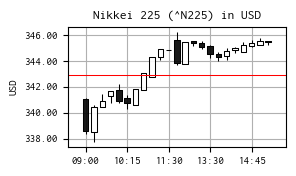

In [12]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose / last_close_usd, color="red", linewidth=0.75)
print("前日終値（ドル換算）", lastclose / last_close_usd)
mpf.plot(
    df2,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
ax.set_ylabel("USD")
ax.grid()

if "shortName" in yticker.info:
    ax.set_title(f"{yticker.info['shortName']} ({symbol}) in USD")
elif "longName" in yticker.info:
    ax.set_title(f"{yticker.info['longName']} ({symbol}) in USD")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart_usd(code, dt_first))
plt.show()